In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from PIL import Image
import glob
import cv2

In [6]:
%load_ext autoreload
%autoreload 2

In [22]:
def crop_background(img):
    mask = img.sum(axis=-1) != 255 
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    img = img[rows.min(): rows.max() + 1, cols.min(): cols.max() + 1]
    img = img.mean(axis=-1)
    return img

def crop_index(img):
    mask = img.sum(axis=-1) != 255 * 3
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    return rows.min(), rows.max() + 1, cols.min(), cols.max() + 1

def crop_by_index(img, index):
    return img[index[0]: index[1], index[2]: index[3]]

""" 
change the image to the gray scale
"""

def to_gray(img):
    return img.mean(axis=-1)

"""
negative the image and make the image black and white
"""
def to_bw(img, threshold=20):
    img = 255 - img
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img
    
def thicken_lines(img, kernel_size=(4,4), iterations=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    dilated_img = cv2.dilate(img, kernel, iterations=iterations)
    return dilated_img

def invert_image(image):
    # Invert the image
    inverted = 255 - image
    return inverted


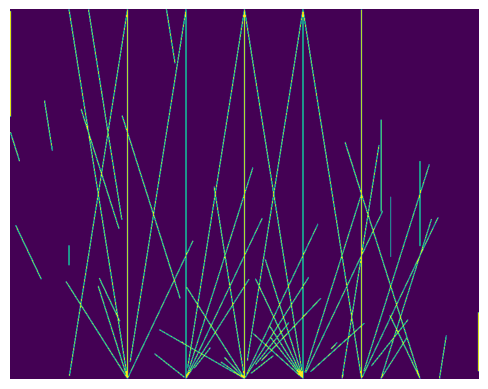

In [23]:
crop_ind = crop_index(np.array(Image.open('testdata/run_001_image_02.png')))
ima = to_bw(crop_by_index(np.array(Image.open('testdata/run_001_image_02.png').convert("L")), crop_ind))
plt.imshow(ima)
plt.axis('off')
plt.show()

In [47]:
edges = cv2.Canny(ima, 50, 150)
# plt.imshow(edges)
hough_zero = 10
# Hough Transform
D = int(512 * np.sqrt(2))
accumulator = np.zeros((2+2*D, 180))  # D is image diagonal
# resize edges to 512x512
edges = cv2.resize(edges, (512, 512))
# for y in range(256):
#     for x in range(150):
#         edges[y,x] = 0



for y in range(edges.shape[0]):
    for x in range(edges.shape[1]):
        if edges[y, x] > hough_zero:
            for theta in range(-90, 90):
                rho = x * np.cos(np.radians(theta)) + y * np.sin(np.radians(theta))
                if rho < 0:
                    print(int(rho))
                    continue
                accumulator[int(rho)+D, theta + 90] += 1

# # Find peaks
# threshold = 100  # Adjust based on your image
# lines = np.where(accumulator > threshold)

# # Convert to line equations
# for rho, theta in zip(lines[0], lines[1]):
#     a = np.cos(np.radians(theta-90))
#     b = np.sin(np.radians(theta-90))
#     x0 = a * (rho-D)
#     y0 = b * (rho-D)
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     cv2.line(image, (x1,y1), (x2,y2), (0,0,255), 2)

# cv2.imshow('Detected Lines', image)
# cv2.waitKey(0)

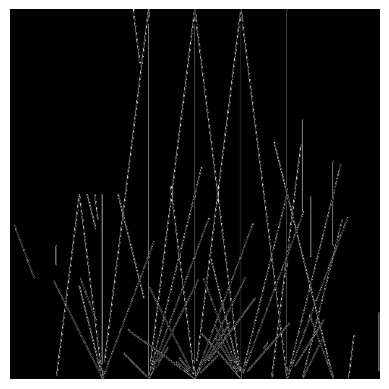

In [48]:
# plot edges 
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()



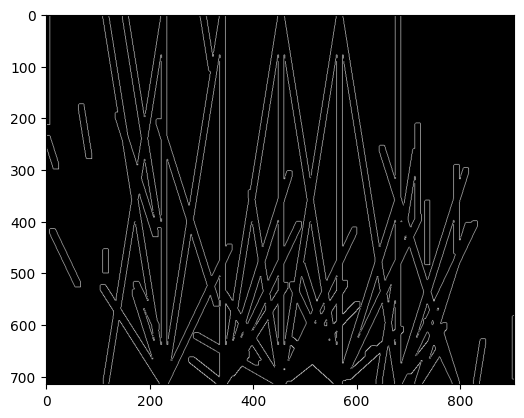

In [73]:
# Step 1: Read and Preprocess the Image
crop_ind = crop_index(np.array(Image.open('testdata/run_001_image_02.png')))
image = to_bw(crop_by_index(np.array(Image.open('testdata/run_001_image_02.png').convert("L")), crop_ind))

gray = thicken_lines(to_bw(crop_by_index(np.array(Image.open('testdata/run_001_image_02.png').convert("L")), crop_ind)))
#gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply Edge Detection
edges = cv2.Canny(gray, 50, 100, apertureSize=3)
plt.imshow(edges, cmap='gray')

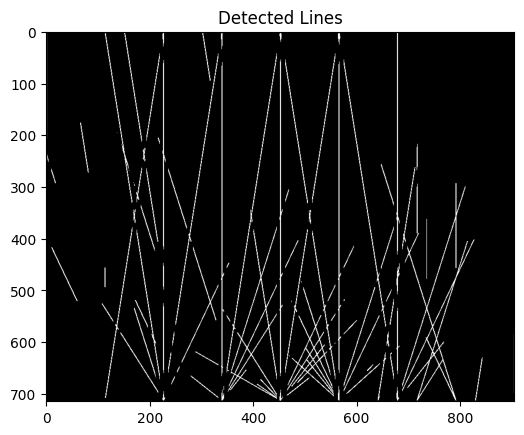

In [94]:

# Step 3: Apply Hough Line Transform
# Using HoughLines method
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

# Using HoughLinesP method for probabilistic approach
linesP = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)


# step 4, show the first line's parameters

# print(lines[1][0])

# Step 4: Draw the Detected Lines
# Drawing lines from HoughLines
# if lines is not None:
#     for rho, theta in lines[:,0]:
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         x1 = int(x0 + 1000 * (-b))
#         y1 = int(y0 + 1000 * (a))
#         x2 = int(x0 - 1000 * (-b))
#         y2 = int(y0 - 1000 * (a))
#         cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 3)

# Drawing lines from HoughLinesP
if linesP is not None:
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.show()

In [95]:
type(image)

numpy.ndarray